Initialisation 

In [1]:
# pip install networkx
# pip install pyproj
# pip install pandas 
# pip install matplotlib 
# pip install folium 

import pandas as pd
import csv
import math
import networkx as nx 
import heapq

# numpy pour dijkstra 
import numpy as np
from numpy import Inf

#Widget
import ipywidgets as widgets
from IPython.display import display

#Map interactive
import folium as f
from folium.plugins import MarkerCluster

#Map pour connection
import matplotlib.pyplot as plt
%matplotlib inline

#Calcul great circle
import pyproj

#import os
#import flightradar24

## Regles de codage 


In [2]:
'''
type_nom_variable
nomFonction(nom_variable : type) 
\'''
    description
    retour :  avec un exemple de forme 
\'''

aeroport ipv airports 
vol --> routesANLO --> df_vols
routes --> dict_routes 

'''

"\ntype_nom_variable\nnomFonction(nom_variable : type) \n'''\n    description\n    retour :  avec un exemple de forme \n'''\n\naeroport ipv airports \nvol --> routesANLO --> df_vols\nroutes --> dict_routes \n\n"

## Importation des données

In [3]:
chemin="../data/"

#df_aeroports = pd.read_csv(chemin + "aeroportsANLO.csv")
#df_zones = pd.read_csv(chemin + "zonesANLO.csv")
df_vols = pd.read_csv(chemin + "routesANLO.csv")
#df_compagnies = pd.read_csv(chemin + "compagniesANLO.csv")

In [4]:
dict_compagnies = {}

with open(chemin+'compagniesANLO.csv', mode='r') as inp:
    reader = csv.reader(inp)
    next(reader, None)
    headers = ['Name','Country']
    dict_compagnies = {rows[2]:dict(zip(headers,[rows[0],rows[3]])) for rows in reader}


In [5]:
dict_aeroports = {}

with open(chemin+'aeroportsANLO.csv', mode='r') as inp:
    reader = csv.reader(inp)
    headers = next(reader, None)
    dict_aeroports = {rows[1]:dict(zip(headers,rows[0:8])) for rows in reader}

dict_aeroports['CDG']

{'Name': 'Paris Charles de Gaulle Airport',
 'Iata': 'CDG',
 'Icao': 'LFPG',
 'Lat': '49.012516',
 'Lon': '2.555752',
 'Country': 'France',
 'Alt': '392',
 'City': 'Paris'}

In [6]:
dict_pays = {}

with open(chemin+'countries.csv', mode='r') as inp:
    reader = csv.reader(inp)
    headers = next(reader, None)
    dict_pays = {rows[1]:rows[0] for rows in reader}

dict_pays

{'Algeria': 'Africa',
 'Angola': 'Africa',
 'Benin': 'Africa',
 'Botswana': 'Africa',
 'Burkina Faso': 'Africa',
 'Burundi': 'Africa',
 'Cameroon': 'Africa',
 'Cape Verde': 'Africa',
 'Central African Republic': 'Africa',
 'Chad': 'Africa',
 'Comoros': 'Africa',
 'Congo': 'Africa',
 'Democratic Republic Of The Congo': 'Africa',
 'Djibouti': 'Africa',
 'Egypt': 'Africa',
 'Equatorial Guinea': 'Africa',
 'Eritrea': 'Africa',
 'Ethiopia': 'Africa',
 'Gabon': 'Africa',
 'Gambia': 'Africa',
 'Ghana': 'Africa',
 'Guinea': 'Africa',
 'Guinea-Bissau': 'Africa',
 "Cote D'ivoire (Ivory Coast)": 'Africa',
 'Kenya': 'Africa',
 'Lesotho': 'Africa',
 'Liberia': 'Africa',
 'Libya': 'Africa',
 'Madagascar': 'Africa',
 'Malawi': 'Africa',
 'Mali': 'Africa',
 'Mauritania': 'Africa',
 'Mauritius': 'Africa',
 'Morocco': 'Africa',
 'Mozambique': 'Africa',
 'Namibia': 'Africa',
 'Niger': 'Africa',
 'Nigeria': 'Africa',
 'Rwanda': 'Africa',
 'Sao Tome And Principe': 'Africa',
 'Senegal': 'Africa',
 'Seychell

In [7]:
df_vols = df_vols[["Depart","Arrivee","Code_ICAO"]].dropna()

In [8]:
#Nettoyage de la df_vols
for _, ligne in df_vols.iterrows():
    if not(ligne.Depart in dict_aeroports):
        df_vols.drop(df_vols[df_vols['Depart'] == ligne.Depart].index, inplace=True)
    
    if not(ligne.Arrivee in dict_aeroports):
        df_vols.drop(df_vols[df_vols['Arrivee'] == ligne.Arrivee].index, inplace=True)

In [9]:
def coordDepuisAeroport(iata : str):
    '''
    Fonction : Recherche les coordonnées GPS d'un aéroport
    Retour : lat : float ,lon : float --> Latitude & longitude de l'aéroport
    '''
    lat = float(dict_aeroports[iata]['Lat'])
    lon = float(dict_aeroports[iata]['Lon'])
    return lat,lon

def DistGrandCercle(lat1 : float, lon1 : float, lat2 : float, lon2 : float):
    #Conversion en radian
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    #Delta des coordonnées
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    #Rayon terrestre (en km)
    r = 6367.0

    #Formule d'Haversine
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    return 2 * r * math.asin(math.sqrt(a))


def DistGrandCercleICAO(icao1 : str, icao2 : str):
    #Récupération des coordonnées des aéroports
    latDep, lonDep = coordDepuisAeroport(icao1)
    latArr, lonArr = coordDepuisAeroport(icao2)

    #On calcule la distance les séparant,                                                     
    return DistGrandCercle(latDep,lonDep,latArr,lonArr)

def Sqr(a):
    return a*a

def Dist(x1,y1,x2,y2):
    return math.sqrt((y2-y1)**2+(x2-x1)**2)

In [10]:
dict_route = {}

g = df_vols.groupby(['Depart','Arrivee'])
taille_groupe = g.size().items()

for liaison, nbrVols in taille_groupe:
    #Si la liaison est déjà dans le dict, on incrémente le nbr de vols
    if(frozenset(liaison) in dict_route):
        dict_route[frozenset(liaison)]['Vols'] += nbrVols
    #Sinon, on crée une nouvelle liaison
    else:
        dict_route[frozenset(liaison)] = {'Dist' : DistGrandCercleICAO(liaison[0],liaison[1]), 'Vols' : nbrVols}

#Exemple :
dict_route[frozenset(('CDG','SIN'))]

{'Dist': 10717.48589664754, 'Vols': 5}

In [11]:
def filtreDictAeroports(colonne : str, valeur : str):
    '''
    Fonction : Filtre les clés du dictionnaire en fonction d'une valeur 
    présente dans les valeurs associées.
    Return : Liste de code ICAO des aéroports
    '''
    Listtmp = []
    for (key, value) in dict_aeroports.items():
        if value[colonne] == valeur:
            Listtmp.append(key)
        
        if valeur == '':
            Listtmp.append(value[colonne])
    return Listtmp

def filtreDictCompagnies(colonne : str, valeur : str):
    '''
    Fonction : Filtre les clés du dictionnaire en fonction d'une valeur 
    présente dans les valeurs associées.
    Return : Liste de code ICAO des compagnies
    '''
    Listtmp = []
    for (key, value) in dict_compagnies .items():
        if value[colonne] == valeur:
            Listtmp.append(key)
            
        if valeur == '':
            Listtmp.append(value[colonne])
    return Listtmp

# Fonctions -- Correspondance 

In [12]:
def correspondanceAirport(code1 : str, code2 : str):
    '''
    fonction qui filtre le df_vols pour obtenir les correspondances
    retour : list des airports codes 
    '''
    r1 = df_vols[df_vols['Depart'] == code1]['Arrivee'].to_list()
    r2 = df_vols[df_vols['Arrivee'] == code2]['Depart'].to_list()

    return list(set(r1).intersection(r2))

In [13]:
def memeContinent(str_air1, str_air2):
    '''
    fonction qui retourne vrai si les deux sont sur le meme continent 
    et faux sinon
    '''
    c1 = dict_aeroports[str_air1]['Country']
    c2 = dict_aeroports[str_air2]['Country']
    
    return c1 == c2
    

def nettoyageList(str_list, str_airStart, str_airEnd):
    '''
    fonction qui supprimer les occurences dans le liste qui ne sont pas sur le 
    meme continent que les airport de depart et d'arrive . 
    '''
    
    if memeContinent(str_airStart, str_airEnd):
        #print('Les airports sont sur le même continent ')
        compteur = 0 ; 
        for element in str_list:
            if not memeContinent(str_airStart, element):
                str_list.remove(element)
                compteur = compteur + 1 
    
    #print('On a enleve {c} airports du list'.format(c = compteur))
    return str_list  
    

In [14]:
def creationEdgesConnection(graphe : nx.Graph, list_reference : list, code1 : str, code2 : str, list_connections_nettoye):
    '''
    fonction qui genere des edges pour notre graphe avec les weights. On appele seulement cette
    focntion si on a le list_connections (qui sont les airports entre code1 et code2)
    retour : list_ref (qui a les index qui corresponds au nodes du graph)
    '''
        
    # pour gerer les correspondances 
    if list_reference.count(code1) == 0: 
        list_reference.append(code1)
        graphe.add_node(list_reference.index(code1))   
    if list_reference.count(code2) == 0: 
        list_reference.append(code2)
        graphe.add_node(list_reference.index(code1))
    
    for i in list_connections_nettoye :
        if list_reference.count(i) == 0 : 
            list_reference.append(i)   
            graphe.add_node(list_reference.index(i))  
    
    index1 = list_reference.index(code1) 
    index2 = list_reference.index(code2)
    
    list_edges = list(map(lambda x :
        (index1, list_reference.index(x), int(DistGrandCercleICAO(code1, x))),
        list_connections_nettoye))
    
    list_edges.extend(list(map(lambda y : 
        (list_reference.index(y), index2, int(DistGrandCercleICAO(y, code2))),
        list_connections_nettoye)))
    #print(list_edges)
    
    #print('nb dans list_ref', len(list_reference))
    graphe.add_weighted_edges_from(list_edges)
    return list_reference

In [15]:
def creationEdgesAucunConnection(graphe : nx.Graph, list_reference : list, code1 : str, code2 : str):
    print(code1, code2)
    posCoteStart = df_vols[df_vols['Depart'] == code1]['Depart'].to_list()
    posCoteEnd = df_vols[df_vols['Arrivee'] == code2]['Depart'].to_list()
    
    if posCoteStart == []: print('Dans notre database, il y a pas des vols qui part de {} .'.format(code1)) ; return False
    if posCoteEnd == []: print('Dans notre database, il y a pas des vols qui arrive sur {} .'.format(code2)); return False
    
    # des le moment que il trouve une chemin pour reliee les deux airports il le fait 
    for i_code in posCoteStart:
        for j_code in posCoteEnd: 
            # verifie si on a une connection 
            tmp = correspondanceAirport(i_code, j_code)
            # si on a une conenction 
            if len(tmp) > 0 :
                # on ajoute les premiere elements 
                list_reference.extend([code1, code2, i_code, j_code])
                edgeStart = (list_reference.index(code1), list_reference.index(i_code), int(DistGrandCercleICAO(code1, i_code)))
                edgeEnd = (list_reference.index(j_code), list_reference.index(code2), int(DistGrandCercleICAO(j_code, code2)))
                
                graphe.add_weighted_edges_from([edgeStart, edgeEnd])
                return creationEdgesConnection(graphe, list_reference, i_code, j_code, tmp)
                 
            
    print('Aucun possiblite pour relie des airports avec trois correspondances (qui est notre max predifini')

In [16]:
def creationEdges(graphe : nx.Graph, list_reference : list, code1 : str, code2 : str):
    '''
        fonction qui crée à partir d'une liste d'aéroports un list des edges d'une graphe (avec le weight)
        et les ajouts dans le graph donne en parametre 
        retour : list des edges ajoute a la graphe [(start , end, weight), (start, end ,weight ) .. ]
    '''
    # dans le listReference les airport recois un index qui corresponds au identifiant de graphe 
    list_connections = correspondanceAirport(code1, code2)
    #print('nb dans list_ref', len(list_reference))
    #print('nb connections', len(list_connections))
   # list_connections_nettoye = nettoyageList(list_connections, code1, code2)
    list_connections_nettoye = list_connections
    
    if(len(list_connections) > 0 ):
      return creationEdgesConnection(graphe, list_reference, code1, code2, list_connections_nettoye)
    else :
        return print("let op functie"); creationEdgesAucunConnection(graphe, list_reference, code1, code2)

In [17]:
def dessinerGraphe(graphe, weighted : bool = False):
    fig = plt.figure(); 
    fig.set_size_inches(15, 15)
    fig.patch.set_facecolor('white')
 
    pos = nx.fruchterman_reingold_layout(graphe)
    nx.draw_networkx_nodes(graphe, pos, node_size = 200)
    nx.draw_networkx_edges(graphe,pos, edgelist= graphe.edges(), edge_color='black')
    nx.draw_networkx_labels(graphe, pos)
    plt.autoscale()
   
    if(weighted): nx.draw_networkx_edge_labels(graphe, pos) # afficher le weight 

    plt.show()

In [18]:
def dijkstra(graphe : nx.Graph, start : int, end : int, list_reference: list):
    '''
        fonction qui utilise l'algorithme de Dijkstra pour calcule le plus court
        chemin et calcule le distance
        retour \: dict{\'distance\' : ... , \'path\' : ...}
    '''
    tmp1 = nx.dijkstra_path(graphe, start,end)
    dist = nx.dijkstra_path_length(graphe, start, end)
    
    tmp1 =  (list(map(lambda x : list_reference[x], tmp1)))
        
    return {'distance' : dist, 'path' : tmp1}

In [19]:
def nombreDeCorrespondances(g : nx.Graph, codeStart, codeFin):
    listRetour = creationEdges(g, [], codeStart, codeFin)
    ## was not  
    if listRetour == [] : 
        listInit = listRetour 
        print('check in nombreDeCorrespondance Edges : ', len(listRetour), g.number_of_edges())
        
        #for i in range(len(listInit)):
        ##    if(len(listRetour) < 300): 
         #       listRetour = creationEdges(g, listRetour, codeStart, listInit[i])
         #       listRetour = creationEdges(g, listRetour, listInit[-i], codeFin)
        
        print('check in nombreDeCorrespondance: ', len(listRetour), g.number_of_nodes())
            
        if g.has_edge(listRetour.index(codeStart), listRetour.index(codeFin)): g.remove_edge(listRetour.index(codeStart), listRetour.index(codeFin))
        if g.has_edge(listRetour.index(codeFin), listRetour.index(codeStart)): g.remove_edge(listRetour.index(codeFin), listRetour.index(codeStart))
            
        return listRetour


In [20]:
def traitementRequest(aeroport_start : str, aeroport_fin : str, g : nx.Graph = nx.Graph()):
    '''
        fonction qui fait le creation de graphe et qui transofrme les nom de airports en node de graphes
        retour : graphe, list_ref (qui est le lien entre le nombr de nodes et le code de airports)
    '''
    aeroport_codeS = filtreDictAeroports('Name', aeroport_start)[0]
    aeroport_codeE = filtreDictAeroports('Name', aeroport_fin)[0] 
    
    list_ref = nombreDeCorrespondances(g, aeroport_codeS, aeroport_codeE)
    
    return g, list_ref
    
def distancePlusCourte(graphe: nx.Graph, list_ref : list, aeroport_codeS, aeroport_codeE):
    '''
        fonction qui trouve le chemin de start aux fin avec le moins de distance possible 
        retour : dictionnaire en forme de {'distance' : .. , 'path' : [ path1, path2 ]}
    '''
    resultat = dijkstra(graphe, list_ref.index(aeroport_codeS), list_ref.index(aeroport_codeE), list_ref)
    return resultat 

def routeAlternatives(graphe : nx.Graph, list_ref : list, int_start : int, int_end : int):
    '''
        fonction qui trouve tous les chemins de start aux fin avec le meme nombr de correspondances 
        que le route plus courte. 
        retour : dictionnaire en forme de {'nbRoute' : .. , 'path' : [ path1, path2 ]}
    '''
    r = list(nx.all_shortest_paths(graphe,source=int_start,target=int_end))    
    tmp = []; 
    for i in r: 
        tmp.append(list(map(lambda x : list_ref[x], i)))
        
    return {'nbRoute' : len(tmp), 'path': tmp}


# Creation du carte/map (en utilisation le code de Loris)

In [21]:
# copie de loris 
def vectGrandCercle(latDep : float, lonDep : float, latArr : float, lonArr : float):
    '''
    Fonction : Calcul un semble de coordonnées permettant de tracer un grand cercle terrestre
    Return : 2 listes de coordonnées
    '''
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(lonDep, latDep, lonArr, latArr)

    # Coordonnée avec des segments <= 100 km
    lonlats = g.npts(lonDep, latDep, lonArr, latArr,
                    1 + int(dist / 100000))

    #Mise en forme
    v1 = []
    v1.append([latDep,lonDep])
    v2 = []
    _lon = lonDep
    _lat = latDep
    horscadre = False
    for lon, lat in lonlats:
        if(not(horscadre) and Dist(_lat,_lon,lat,lon) < 4):        
            v1.append([lat,lon])
        else:
            horscadre = True
            v2.append([lat,lon])
        _lon = lon
        _lat = lat
    
    if(horscadre):
        v2.append([latArr,lonArr])
    else:
        v1.append([latArr,lonArr])

    return v1,v2

In [22]:
# dérivé du fonction de loris 
def map_correspondance(path,m):
    '''
    fonction qui genere les lines pour le map des correspondances 
    le variable path est du forme [str, str, str ...]
    '''
    Line_monde = f.FeatureGroup(name = "International")
    Line_continent = f.FeatureGroup(name = "Continental")
    Line_pays = f.FeatureGroup(name = "National")   
    print(path)
    for element in range(len(path)-1) :
        #Certains aéroports n'ont pas de correspondance dans le dict. Pour éviter l'erreur -> try puis pass
        try:
            start = path[element]
            end = path[element+1]
            latDep, lonDep = coordDepuisAeroport(start)
            latArr, lonArr = coordDepuisAeroport(end)
            
            #Calcul des chemins à afficher
            v2 = []
            v1,v2 = vectGrandCercle(latDep,lonDep,latArr,lonArr)

            #Test vol national ou international
            if(dict_aeroports[start]['Country'] == dict_aeroports[end]['Country']):
                Line_group = Line_pays
                col_ligne = "#80F0A3"
                col_marker = "#008329"
            elif(dict_pays[dict_aeroports[start]['Country']] == dict_pays[dict_aeroports[end]['Country']] ):
                Line_group = Line_continent
                col_ligne = "#F6FF28"
                col_marker = "#FE7700"
            else:
                Line_group = Line_monde
                col_ligne = "#563DFF"
                col_marker = "#0004A8"


            #-------------------
            f.PolyLine(locations=v1,weight=1, color=col_ligne).add_to(Line_group)
            if(len(v2) != 0):
                f.PolyLine(locations=v2,weight=1, color=col_ligne).add_to(Line_group)
            
            f.CircleMarker(location = [latArr, lonArr],
                            radius = 1, 
                            color = col_marker, 
                            tooltip=dict_aeroports[end]['City'],
                            popup="<b>Nom : </b>" + dict_aeroports[end]['Name'] + """<br />
                                    <b>Code :</b> """ + dict_aeroports[end]['Iata'] + """<br />
                                    <b>Coordonnées :</b> (""" + str(dict_aeroports[end]['Lat']) + ";" + str(dict_aeroports[end]['Lon']) + """)<br />
                                    <b>City : </b>""" + str(dict_aeroports[end]['City']) + """<br />
                                    <b>Pays : </b>""" + dict_aeroports[end]['Country']).add_to(Line_group)
        except:
            pass
    
    #Ajout des layers à la carte
    Line_monde.add_to(m)
    Line_continent.add_to(m)
    Line_pays.add_to(m)
    
    f.TileLayer('cartodbdark_matter').add_to(m)
    f.LayerControl().add_to(m)

In [23]:
def map_tous_correspondances(collection, m): 
    '''
    fonction qui itere sur une collection des paths 
    colection doit être du forme [ [str, str, str ...], [str, str, etc], etc ]
    '''

    #Paramètre de la carte
    #f.TileLayer('cartodbdark_matter').add_to(m)
    for p in collection : 
        map_correspondance(p, m)
    f.LayerControl().add_to(m)


In [24]:
## marche seulement pour les petit relations 
def routeSelonNombreCorrespondances(graphe : nx.Graph, nombre : int, start, end):
    '''
        fonction qui trouve tous les chemins de start aux fin avec 'nombre' correspondances
        retour : dictionnaire en forme de {'nbRoute' : .. , 'path' : [ path1, path2 ]}
    '''
    r2 = list(nx.all_simple_paths(graphe,source=start,target=end))    
    r3 = list(filter(lambda x : len(x) == nombre, r2))
    
    return {'nbRoute' : len(r3), 'path': r3}

def routeSelonNombreCorrespondanceLessThen(graphe : nx.Graph, nombre : int, start, end):
    '''
        fonction qui retourne tous les routes/correspondances avec un nombre de correspondances <= nombre 
        retour : un dictionnaire { nombre : {'nbRoute' : .. , 'path' : [ path1, path2 ]}, nombre2 : {..}}
    '''
    r1 = list(nx.all_simple_paths(graphe,source=start,target=end))    
    r2 = list(filter(lambda x : len(x) <= nombre, r1))
    
    return {'nbRoute' : len(r2), 'path': r2}


Widget StoryLine 

In [25]:
airportArrive = widgets.Dropdown(
    value = 'Amsterdam Schiphol Airport',
    options= filtreDictAeroports('Name', ''),
    description='Airport Depart:',
    disabled=False,
)

airportDepart = widgets.Dropdown(
    value = 'Los Angeles International Airport',
    options= filtreDictAeroports('Name', ''),
    description='Airport Depart:',
    disabled=False,
)

recommandationSelon = widgets.RadioButtons(
    options = {'direct', 'distance', 'alternatives'}, 
    description = 'Recommendation selon : ',
    disable = False, 
)

In [26]:
airportArrive

Dropdown(description='Airport Depart:', index=126, options=('A Coruna Airport', 'Aachen Merzbruck Airport', 'A…

In [27]:
airportDepart

Dropdown(description='Airport Depart:', index=2329, options=('A Coruna Airport', 'Aachen Merzbruck Airport', '…

In [28]:
recommandationSelon

RadioButtons(description='Recommendation selon : ', options=('alternatives', 'direct', 'distance'), value='alt…

In [29]:
print(airportArrive.value,',' , airportDepart.value,',' , recommandationSelon.value)
# Lyon Saint Exupery Airport , Vilnius International Airport , alternatives --> werkt niet 

Amsterdam Schiphol Airport , Los Angeles International Airport , alternatives


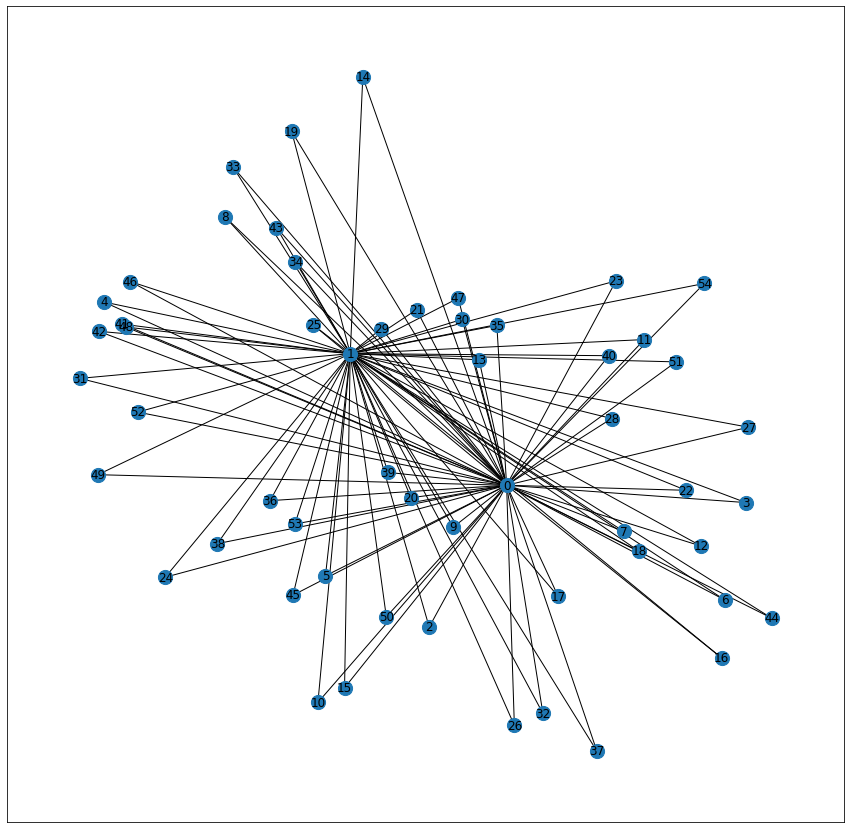

In [30]:
codeStart = filtreDictAeroports('Name', airportArrive.value)[0]
codeEnd = filtreDictAeroports('Name', airportDepart.value)[0] 

graph_widget, list_ref = traitementRequest(airportArrive.value, airportDepart.value)

if( graph_widget.number_of_nodes() > 0):
    dessinerGraphe(graph_widget)

else : print('On n\'a pas trouve une correspondance')

# geen overstap direct --> aarhus naar LAX

In [31]:
del graph_widget

In [32]:
from IPython.core.display import display, HTML

def folium_deepnote_show(m):
    data = m.get_root().render()
    data_fixed_height = data.replace('width: 50%;height: 50%', 'width: 100%').replace('height: 50.0%;', 'height: 609px;', 1)
    display(HTML(data_fixed_height))

C:\Users\Merel\AppData\Local\Temp\ipykernel_15316\2982268536.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [33]:
m = f.Map(
    location = [0, 0],
    zoom_start = 2.3,
    min_zoom  = 2,
    min_lot=-180,
    max_lot=180,
    min_lat=-90,
    max_lat=90,
    max_bounds=True,
)

x = list_ref.index(codeStart)
y = list_ref.index(codeEnd)

if(recommandationSelon.value == 'direct'): 
    tmp = df_vols[df_vols['Depart'] == codeStart]
    tmp2 = tmp[tmp['Arrivee'] == codeEnd] ; 
    if len(tmp2) > 0 :
        print(' il y a une vol direct ')
        print(tmp2)
    else: print('il n\'y pas une vol direct, essayez une autre option') ; recommandationSelon;

if(recommandationSelon.value == 'distance'): 
    resultat = distancePlusCourte(graph_widget, list_ref, codeStart, codeEnd) 
    print(resultat)
    map_correspondance(resultat['path'], m)
    #map_tous_correspondances(resultat['path'], m)
    #map_tous_correspondances(resultat['path'])
    
    
if(recommandationSelon.value == 'alternatives'): 
    resultat =  routeAlternatives(graph_widget, list_ref, x, y)
    print(resultat)
    for i in resultat['path']:
        map_correspondance(i, m )
    
        

m


AttributeError: 'NoneType' object has no attribute 'index'

In [ ]:
# ces calculations sont tres couteux et pouvait seulement entre fait si on a une petit graphe 
if graph_widget.number_of_nodes() < 200 or graph_widget.number_of_edges() < 1000 :
    print('c\' est un graphe petit donc on peut se permettre de donnee plus de details : ')
    resultat2 = routeSelonNombreCorrespondanceLessThen(graph_widget, 6, x , y)
    print(resultat2)
    map_tous_correspondances(resultat2['path'])


: 

: 